In [ ]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
import math
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader as TorchDataLoader, Dataset as TorchDataset, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.cluster import KMeans
from sklearn.exceptions import ConvergenceWarning
import warnings

warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn')

SEED = 42
SUBSET_SIZE = 15000
VALIDATION_SPLIT = 0.2
RESIZE_DIM = 128

VAE_LATENT_DIM = 128
VAE_WEIGHTS_PATH = "/kaggle/input/vae/pytorch/default/1/best_vae_model_weights-main.pth"

NUM_BINS = 256
SEQ_LEN = VAE_LATENT_DIM
TRANSFORMER_DIM = 256
N_HEADS = 8
N_LAYERS = 6
DROPOUT = 0.1
KMEANS_FIT_SAMPLES = 12000

BATCH_SIZE_IMG = 64
T_BATCH_SIZE = 64
T_LEARNING_RATE = 1e-4
T_NUM_EPOCHS = 30

NUM_GENERATE = 100

data_path = "/kaggle/input/falcon/quark-gluon_data-set_n139306.hdf5"

torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if not os.path.exists(data_path):
     raise FileNotFoundError(f"Dataset HDF5 file not found at: {data_path}")


Using device: cuda


In [ ]:
print(f"Loading data from: {data_path}")
with h5py.File(data_path, 'r') as f:
    print("Keys in dataset:", list(f.keys()))
    total_samples_in_file = len(f['X_jets'])
    if SUBSET_SIZE:
        n_load = min(SUBSET_SIZE, total_samples_in_file)
        print(f"Loading subset: {n_load} samples.")
        X_jets_raw = f['X_jets'][:n_load]
    else:
        print(f"Loading full dataset: {total_samples_in_file} samples.")
        X_jets_raw = f['X_jets'][:]
    print(f"Loaded raw X_jets shape: {X_jets_raw.shape}")

X_jets_tensor = torch.tensor(X_jets_raw, dtype=torch.float32).permute(0, 3, 1, 2)
del X_jets_raw

if X_jets_tensor.shape[-2:] != (RESIZE_DIM, RESIZE_DIM):
    print(f"Resizing images to {RESIZE_DIM}x{RESIZE_DIM}...")
    X_jets_resized = F.interpolate(X_jets_tensor, size=(RESIZE_DIM, RESIZE_DIM), mode='bilinear', align_corners=False)
else:
    X_jets_resized = X_jets_tensor
print(f"Resized X_jets shape: {X_jets_resized.shape}")
del X_jets_tensor

n_total = len(X_jets_resized)
n_val = int(VALIDATION_SPLIT * n_total)
n_train = n_total - n_val
indices = np.arange(n_total)
np.random.shuffle(indices)

train_indices = indices[:n_train]
val_indices = indices[n_train:]
print(f"Total: {n_total}, Train: {n_train}, Val: {n_val}")

print("Calculating normalization statistics on the training set...")
train_data_for_norm = X_jets_resized[train_indices].cpu()
channel_means = train_data_for_norm.mean(dim=[0, 2, 3], keepdim=True)
channel_stds = train_data_for_norm.std(dim=[0, 2, 3], keepdim=True)
channel_stds[channel_stds == 0] = 1e-6
print(f"Channel Means: {channel_means.squeeze().tolist()}")
print(f"Channel Stds: {channel_stds.squeeze().tolist()}")
del train_data_for_norm

X_jets_normalized = (X_jets_resized - channel_means) / channel_stds
del X_jets_resized
print(f"Normalized X_jets shape: {X_jets_normalized.shape}")

vmin_plot, vmax_plot = -3, 3

image_base_dataset = TensorDataset(X_jets_normalized)
train_img_dataset = Subset(image_base_dataset, train_indices)
val_img_dataset = Subset(image_base_dataset, val_indices)

try: num_workers = min(os.cpu_count() // 2, 4)
except NotImplementedError: num_workers = 0
print(f"Using {num_workers} workers for Image DataLoaders.")

train_loader_img = TorchDataLoader(train_img_dataset, batch_size=BATCH_SIZE_IMG, shuffle=True, num_workers=num_workers)
val_loader_img = TorchDataLoader(val_img_dataset, batch_size=BATCH_SIZE_IMG, shuffle=False, num_workers=num_workers)

print(f"Image Training set size: {len(train_img_dataset)}")
print(f"Image Validation set size: {len(val_img_dataset)}")
print("Image DataLoaders created.")

Loading data from: /kaggle/input/falcon/quark-gluon_data-set_n139306.hdf5
Keys in dataset: ['X_jets', 'm0', 'pt', 'y']
Loading subset: 15000 samples.
Loaded raw X_jets shape: (15000, 125, 125, 3)
Resizing images to 128x128...
Resized X_jets shape: torch.Size([15000, 3, 128, 128])
Total: 15000, Train: 12000, Val: 3000
Calculating normalization statistics on the training set...
Channel Means: [7.889019616413862e-05, 4.965145853930153e-05, 3.1258932722266763e-05]
Channel Stds: [0.003909220919013023, 0.0014356673927977681, 0.00047582612023688853]
Normalized X_jets shape: torch.Size([15000, 3, 128, 128])
Using 2 workers for Image DataLoaders.
Image Training set size: 12000
Image Validation set size: 3000
Image DataLoaders created.


In [ ]:
class Encoder(nn.Module):
    def __init__(self, latent_dim=128, input_channels=3, base_filters=32):
        super(Encoder, self).__init__()
        self.conv1=nn.Conv2d(input_channels,base_filters,3,2,1); self.bn1=nn.BatchNorm2d(base_filters)
        self.conv2=nn.Conv2d(base_filters,base_filters*2,3,2,1); self.bn2=nn.BatchNorm2d(base_filters*2)
        self.conv3=nn.Conv2d(base_filters*2,base_filters*4,3,2,1); self.bn3=nn.BatchNorm2d(base_filters*4)
        self.conv4=nn.Conv2d(base_filters*4,base_filters*8,3,2,1); self.bn4=nn.BatchNorm2d(base_filters*8)
        self.flatten=nn.Flatten(); flattened_size=base_filters*8*(RESIZE_DIM//16)*(RESIZE_DIM//16)
        self.fc1=nn.Linear(flattened_size,1024); self.fc_mu=nn.Linear(1024,latent_dim); self.fc_logvar=nn.Linear(1024,latent_dim)
    def forward(self,x):
        x=F.relu(self.bn1(self.conv1(x))); x=F.relu(self.bn2(self.conv2(x))); x=F.relu(self.bn3(self.conv3(x))); x=F.relu(self.bn4(self.conv4(x)))
        x=self.flatten(x); x=F.relu(self.fc1(x)); mu=self.fc_mu(x); logvar=self.fc_logvar(x); return mu,logvar

class Decoder(nn.Module):
    def __init__(self,latent_dim=128,output_channels=3,base_filters=32,resize_dim=128):
        super(Decoder,self).__init__(); self.latent_dim=latent_dim; self.base_filters=base_filters; self.resize_dim=resize_dim
        self.unflatten_dim=base_filters*8; self.unflatten_size=self.resize_dim//16; self.fc=nn.Linear(latent_dim,self.unflatten_dim*self.unflatten_size*self.unflatten_size)
        self.deconv1=nn.ConvTranspose2d(self.unflatten_dim,base_filters*4,3,2,1,1); self.bn1=nn.BatchNorm2d(base_filters*4)
        self.deconv2=nn.ConvTranspose2d(base_filters*4,base_filters*2,3,2,1,1); self.bn2=nn.BatchNorm2d(base_filters*2)
        self.deconv3=nn.ConvTranspose2d(base_filters*2,base_filters,3,2,1,1); self.bn3=nn.BatchNorm2d(base_filters)
        self.deconv4=nn.ConvTranspose2d(base_filters,output_channels,3,2,1,1)
    def forward(self,z):
        x=F.relu(self.fc(z)); x=x.view(-1,self.unflatten_dim,self.unflatten_size,self.unflatten_size)
        x=F.relu(self.bn1(self.deconv1(x))); x=F.relu(self.bn2(self.deconv2(x))); x=F.relu(self.bn3(self.deconv3(x))); x=self.deconv4(x); return x

class VAE(nn.Module):
    def __init__(self,latent_dim=128,input_channels=3,base_filters=32,resize_dim=128):
        super(VAE,self).__init__(); self.encoder=Encoder(latent_dim,input_channels,base_filters)
        self.decoder=Decoder(latent_dim,input_channels,base_filters,resize_dim)
    def reparameterize(self,mu,logvar): std=torch.exp(0.5*logvar);eps=torch.randn_like(std);return mu+eps*std
    def forward(self,x): mu,logvar=self.encoder(x); z=self.reparameterize(mu,logvar); recon=self.decoder(z); return recon,mu,logvar

print(f"Instantiating VAE model with LATENT_DIM={VAE_LATENT_DIM}")
vae_model = VAE(latent_dim=VAE_LATENT_DIM, resize_dim=RESIZE_DIM).to(device)
vae_model_loaded = False

print(f"Attempting to load VAE weights from: {VAE_WEIGHTS_PATH}")
if os.path.exists(VAE_WEIGHTS_PATH):
    try:
        state_dict = torch.load(VAE_WEIGHTS_PATH, map_location=device)
        vae_model.load_state_dict(state_dict)
        print(f"Successfully loaded VAE weights.")
        vae_model_loaded = True
        vae_model.eval()
    except Exception as e:
        print(f"--- Error loading VAE weights: {e} ---")
else:
    print(f"--- VAE weights file not found at: {VAE_WEIGHTS_PATH} ---")

if not vae_model_loaded:
    raise RuntimeError("VAE weights could not be loaded. Cannot proceed.")

Instantiating VAE model with LATENT_DIM=128
Attempting to load VAE weights from: /kaggle/input/vae/pytorch/default/1/best_vae_model_weights-main.pth


<ipython-input-4-b96932c1fe08>:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(VAE_WEIGHTS_PATH, map_location=device)


Successfully loaded VAE weights.


To enable the Transformer to work with the VAE's continuous latent space, we need to discretize it. This cell performs the setup for this discretization by determining representative "bins" for each latent dimension using K-Means clustering. Because fitting K-Means on the latent vectors of the entire training set can be computationally expensive (especially when repeated for each of the 128 dimensions), we perform this fitting on a smaller, representative subset of the training data. Latent mean vectors (`mu`) are generated for this subset using the loaded VAE encoder. Then, for each of the 128 latent dimensions independently, a `KMeans` model is trained to group the observed values for that dimension into `NUM_BINS` clusters. The center (centroid) of each cluster represents a discrete level or bin for that dimension. These calculated bin centers are stored in the `bin_centers_np` array (shape `[128, NUM_BINS]`). The fitted `KMeans` models are also temporarily stored to facilitate the discretization of the full dataset in the next cell. The resulting `bin_centers_tensor` defines the discrete vocabulary used for representing latennt vectors.

In [ ]:
n_kmeans_fit = min(KMEANS_FIT_SAMPLES, len(train_img_dataset))
print(f"Fitting KMeans on a subset of {n_kmeans_fit} training samples...")

kmeans_subset_indices = np.random.choice(len(train_img_dataset), n_kmeans_fit, replace=False)
kmeans_fit_dataset = Subset(train_img_dataset, kmeans_subset_indices)
kmeans_loader = TorchDataLoader(kmeans_fit_dataset, batch_size=BATCH_SIZE_IMG * 4, shuffle=False, num_workers=num_workers)

mus_for_kmeans_list = []
vae_model.eval()
with torch.no_grad():
    for data_batch in tqdm(kmeans_loader, desc="Encoding KMeans Subset"):
        if isinstance(data_batch, (list, tuple)): data = data_batch[0].to(device)
        elif isinstance(data_batch, torch.Tensor): data = data_batch.to(device)
        else: continue
        mu, _ = vae_model.encoder(data)
        mus_for_kmeans_list.append(mu.cpu())

mus_for_kmeans = torch.cat(mus_for_kmeans_list, dim=0).numpy()
print(f"Subset latent vectors shape for KMeans fit: {mus_for_kmeans.shape}")
del mus_for_kmeans_list, kmeans_loader, kmeans_fit_dataset, data_batch, data, mu

print(f"Fitting {VAE_LATENT_DIM} KMeans models (k={NUM_BINS})...")
bin_centers_np = np.zeros((VAE_LATENT_DIM, NUM_BINS), dtype=np.float32)
kmeans_models = []

start_time = time.time()
for dim in tqdm(range(VAE_LATENT_DIM), desc="Fitting KMeans per Dim", leave=False):
    kmeans = KMeans(n_clusters=NUM_BINS, random_state=SEED + dim, n_init=10, max_iter=100)
    dim_data = mus_for_kmeans[:, dim].reshape(-1, 1)
    kmeans.fit(dim_data)
    centers = np.sort(kmeans.cluster_centers_.flatten())
    if len(centers) != NUM_BINS:
        padded_centers = np.pad(centers, (0, NUM_BINS - len(centers)), mode='edge')
        bin_centers_np[dim, :] = padded_centers
    else:
        bin_centers_np[dim, :] = centers
    kmeans_models.append(kmeans)

end_time = time.time()
print(f"KMeans fitting finished in {end_time - start_time:.2f} seconds.")
print(f"Shape of bin centers: {bin_centers_np.shape}")

bin_centers_tensor = torch.tensor(bin_centers_np, dtype=torch.float32).to(device)
del mus_for_kmeans

Fitting KMeans on a subset of 12000 training samples...


Encoding KMeans Subset:   0%|          | 0/47 [00:00<?, ?it/s]

Subset latent vectors shape for KMeans fit: (12000, 128)
Fitting 128 KMeans models (k=256)...


Fitting KMeans per Dim:   0%|          | 0/128 [00:00<?, ?it/s]

KMeans fitting finished in 366.42 seconds.
Shape of bin centers: (128, 256)


With thee discretization scheme established, this cell converts the continuous latent vectors for the *entire* training set into sequences of discrete integer codes. These sequences form the actual training data for the Transformer. To handle potentially large datasets without exceeding memory limits, this conversion is performed in batches. A `DataLoader` iterates through the full training image dataset batch by batch. For each image batch, the VAE encoder generates the corresponding latent mean vectors (`mu`). Then, for each latent dimension, the pre-fitted K-Means model for that dimension (from `kmeans_models`) is used to predict the nearest bin center index (a code from 0 to `NUM_BINS-1`) for each vector's value in that dimension. These integer codes for the batch are collected and stored in the appropriate rows of a pre-allocated NumPy array, `train_codes_np`. This batch-wise encoding-and-predicting avoids holding all floating-point latent vectors in memory simultaneously. Finally, the completed NumPy array of codes is converted into the `train_codes_tensor`, ready for the Transformer.

In [ ]:
print(f"Generating and discretizing codes for all {len(train_img_dataset)} training samples...")
train_codes_np = np.zeros((len(train_img_dataset), VAE_LATENT_DIM), dtype=np.int64)

full_train_loader = TorchDataLoader(train_img_dataset, batch_size=BATCH_SIZE_IMG * 2, shuffle=False, num_workers=num_workers)

processed_samples = 0
vae_model.eval()
with torch.no_grad():
    for data_batch in tqdm(full_train_loader, desc="Generating/Discretizing Codes"):
        if isinstance(data_batch, (list, tuple)): data = data_batch[0].to(device)
        elif isinstance(data_batch, torch.Tensor): data = data_batch.to(device)
        else: continue

        current_batch_size = data.shape[0]
        mu, _ = vae_model.encoder(data)
        mu_cpu = mu.cpu().numpy()

        codes_batch = np.zeros((current_batch_size, VAE_LATENT_DIM), dtype=np.int64)
        for dim in range(VAE_LATENT_DIM):
            dim_data = mu_cpu[:, dim].reshape(-1, 1)
            codes_batch[:, dim] = kmeans_models[dim].predict(dim_data)

        start_idx = processed_samples
        end_idx = processed_samples + current_batch_size
        train_codes_np[start_idx:end_idx, :] = codes_batch
        processed_samples = end_idx

print(f"Finished generating/discretizing codes. Total samples processed: {processed_samples}")
print(f"Shape of final training codes: {train_codes_np.shape}")

train_codes_tensor = torch.tensor(train_codes_np, dtype=torch.long)

del full_train_loader, data_batch, data, mu, mu_cpu, codes_batch, kmeans_models, train_codes_np

Generating and discretizing codes for all 12000 training samples...


Generating/Discretizing Codes:   0%|          | 0/94 [00:00<?, ?it/s]

Finished generating/discretizing codes. Total samples processed: 12000
Shape of final training codes: (12000, 128)


In [ ]:
class LatentCodeDataset(TorchDataset):
    def __init__(self, codes_tensor):
        self.codes = codes_tensor
    def __len__(self):
        return self.codes.shape[0]
    def __getitem__(self, idx):
        return self.codes[idx]

transformer_dataset = LatentCodeDataset(train_codes_tensor)
transformer_train_loader = TorchDataLoader(transformer_dataset, batch_size=T_BATCH_SIZE, shuffle=True, num_workers=0)

print(f"Created Transformer Dataset with {len(transformer_dataset)} sequences.")
print(f"Sequence length: {SEQ_LEN}")
print(f"Vocabulary size (NUM_BINS): {NUM_BINS}")

Created Transformer Dataset with 12000 sequences.
Sequence length: 128
Vocabulary size (NUM_BINS): 256


This cell defines the `GenerativeTransformer`, the core model responsible for learning and generating sequences of discrete latent codes. It employs a decoder-only Transformer architecture, conceptually similar to models like GPT, designed for autoregressive sequence generation. Key components include an `nn.Embedding` layer to map the input discrete bin indices (tokens) to dense vectors, standard `PositionalEncoding` to provide sequence order information, and a stack of `nn.TransformerDecoderLayer` blocks. Each decoder layer contains causal self-attention, allowing a position to attend only to preceding positions (enforced by `generate_square_subsequent_mask`), followed by a feed-forward network. The stack of these layers forms the `nn.TransformerDecoder`. Finally, an `nn.Linear` output layer maps the processed vectors back to logits over the vocabulary (`VOCAB_SIZE = NUM_BINS`), predicting the likelihood of each possible bin index for the *next* position in the sequence.

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=500):
        super().__init__(); self.dropout=nn.Dropout(p=dropout)
        position=torch.arange(max_len).unsqueeze(1); div_term=torch.exp(torch.arange(0,d_model,2)*(-math.log(10000.0)/d_model))
        pe=torch.zeros(max_len,1,d_model); pe[:,0,0::2]=torch.sin(position*div_term); pe[:,0,1::2]=torch.cos(position*div_term)
        self.register_buffer('pe',pe)
    def forward(self,x): x=x+self.pe[:x.size(0)]; return self.dropout(x)

class GenerativeTransformer(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, num_decoder_layers, dim_feedforward, max_seq_len, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout, max_seq_len)
        decoder_layer = nn.TransformerDecoderLayer(d_model, nhead, dim_feedforward, dropout, batch_first=True, activation=F.gelu)
        decoder_norm = nn.LayerNorm(d_model)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_decoder_layers, decoder_norm)
        self.output_layer = nn.Linear(d_model, vocab_size)

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, src):
        tgt_mask = self.generate_square_subsequent_mask(src.size(1)).to(src.device)
        src_emb = self.token_embedding(src) * math.sqrt(self.d_model)
        src_pos = self.pos_encoder(src_emb.transpose(0, 1)).transpose(0, 1)
        output = self.transformer_decoder(tgt=src_pos, memory=src_pos, tgt_mask=tgt_mask)
        logits = self.output_layer(output)
        return logits

VOCAB_SIZE = NUM_BINS
transformer_model = GenerativeTransformer(
    vocab_size=VOCAB_SIZE,
    d_model=TRANSFORMER_DIM,
    nhead=N_HEADS,
    num_decoder_layers=N_LAYERS,
    dim_feedforward=TRANSFORMER_DIM * 4,
    max_seq_len=SEQ_LEN,
    dropout=DROPOUT
).to(device)

print(transformer_model)
num_params_t = sum(p.numel() for p in transformer_model.parameters() if p.requires_grad)
print(f"\nNumber of trainable parameters in Transformer: {num_params_t:,}")

GenerativeTransformer(
  (token_embedding): Embedding(256, 256)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_decoder): TransformerDecoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=1024, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=1024, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm3): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dr

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer_t = optim.AdamW(transformer_model.parameters(), lr=T_LEARNING_RATE)
scheduler_t = ReduceLROnPlateau(optimizer_t, mode='min', factor=0.2, patience=3, verbose=True)

t_train_losses = []
t_model_save_path = "best_transformer_generator_weights.pth"
best_t_loss = float('inf')

print("Starting Transformer Training...")
transformer_model.train()

for epoch in range(1, T_NUM_EPOCHS + 1):
    epoch_loss = 0
    num_batches = 0
    train_pbar_t = tqdm(transformer_train_loader, desc=f"Epoch {epoch}/{T_NUM_EPOCHS} [Transformer Train]", leave=False)

    for sequence_batch in train_pbar_t:
        sequence_batch = sequence_batch.to(device)
        src = sequence_batch[:, :-1]
        tgt = sequence_batch[:, 1:]
        if src.shape[1] == 0: continue

        optimizer_t.zero_grad()
        logits = transformer_model(src)
        loss = criterion(logits.reshape(-1, VOCAB_SIZE), tgt.reshape(-1))

        if torch.isnan(loss): print(f"Warning: NaN loss detected epoch {epoch}. Skipping batch."); continue
        loss.backward()
        torch.nn.utils.clip_grad_norm_(transformer_model.parameters(), max_norm=1.0)
        optimizer_t.step()
        epoch_loss += loss.item(); num_batches += 1
        train_pbar_t.set_postfix(loss=loss.item())

    if num_batches > 0:
        avg_epoch_loss = epoch_loss / num_batches
        t_train_losses.append(avg_epoch_loss)
        print(f"Epoch {epoch:2d}: Avg Train Loss: {avg_epoch_loss:.4f} | LR: {optimizer_t.param_groups[0]['lr']:.1e}")
        if avg_epoch_loss < best_t_loss:
            best_t_loss = avg_epoch_loss
            torch.save(transformer_model.state_dict(), t_model_save_path)
            print(f" *** Saved new best Transformer model with loss: {best_t_loss:.4f} ***")
        scheduler_t.step(avg_epoch_loss)
    else: print(f"Epoch {epoch:2d}: No valid batches processed.")

print("Transformer Training Finished!")
if os.path.exists(t_model_save_path):
    print(f"Loading best Transformer weights from {t_model_save_path}")
    transformer_model.load_state_dict(torch.load(t_model_save_path, map_location=device))
else: print("Warning: No saved Transformer weights found.")

Starting Transformer Training...


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/30 [Transformer Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch  1: Avg Train Loss: 5.6136 | LR: 1.0e-04
 *** Saved new best Transformer model with loss: 5.6136 ***


Epoch 2/30 [Transformer Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch  2: Avg Train Loss: 5.5274 | LR: 1.0e-04
 *** Saved new best Transformer model with loss: 5.5274 ***


Epoch 3/30 [Transformer Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch  3: Avg Train Loss: 5.5134 | LR: 1.0e-04
 *** Saved new best Transformer model with loss: 5.5134 ***


Epoch 4/30 [Transformer Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch  4: Avg Train Loss: 5.5056 | LR: 1.0e-04
 *** Saved new best Transformer model with loss: 5.5056 ***


Epoch 5/30 [Transformer Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch  5: Avg Train Loss: 5.5016 | LR: 1.0e-04
 *** Saved new best Transformer model with loss: 5.5016 ***


Epoch 6/30 [Transformer Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch  6: Avg Train Loss: 5.4979 | LR: 1.0e-04
 *** Saved new best Transformer model with loss: 5.4979 ***


Epoch 7/30 [Transformer Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch  7: Avg Train Loss: 5.4930 | LR: 1.0e-04
 *** Saved new best Transformer model with loss: 5.4930 ***


Epoch 8/30 [Transformer Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch  8: Avg Train Loss: 5.4895 | LR: 1.0e-04
 *** Saved new best Transformer model with loss: 5.4895 ***


Epoch 9/30 [Transformer Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch  9: Avg Train Loss: 5.4869 | LR: 1.0e-04
 *** Saved new best Transformer model with loss: 5.4869 ***


Epoch 10/30 [Transformer Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 10: Avg Train Loss: 5.4844 | LR: 1.0e-04
 *** Saved new best Transformer model with loss: 5.4844 ***


Epoch 11/30 [Transformer Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 11: Avg Train Loss: 5.4824 | LR: 1.0e-04
 *** Saved new best Transformer model with loss: 5.4824 ***


Epoch 12/30 [Transformer Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 12: Avg Train Loss: 5.4804 | LR: 1.0e-04
 *** Saved new best Transformer model with loss: 5.4804 ***


Epoch 13/30 [Transformer Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 13: Avg Train Loss: 5.4786 | LR: 1.0e-04
 *** Saved new best Transformer model with loss: 5.4786 ***


Epoch 14/30 [Transformer Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 14: Avg Train Loss: 5.4766 | LR: 1.0e-04
 *** Saved new best Transformer model with loss: 5.4766 ***


Epoch 15/30 [Transformer Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 15: Avg Train Loss: 5.4747 | LR: 1.0e-04
 *** Saved new best Transformer model with loss: 5.4747 ***


Epoch 16/30 [Transformer Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 16: Avg Train Loss: 5.4724 | LR: 1.0e-04
 *** Saved new best Transformer model with loss: 5.4724 ***


Epoch 17/30 [Transformer Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 17: Avg Train Loss: 5.4703 | LR: 1.0e-04
 *** Saved new best Transformer model with loss: 5.4703 ***


Epoch 18/30 [Transformer Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 18: Avg Train Loss: 5.4680 | LR: 1.0e-04
 *** Saved new best Transformer model with loss: 5.4680 ***


Epoch 19/30 [Transformer Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 19: Avg Train Loss: 5.4660 | LR: 1.0e-04
 *** Saved new best Transformer model with loss: 5.4660 ***


Epoch 20/30 [Transformer Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 20: Avg Train Loss: 5.4641 | LR: 1.0e-04
 *** Saved new best Transformer model with loss: 5.4641 ***


Epoch 21/30 [Transformer Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 21: Avg Train Loss: 5.4620 | LR: 1.0e-04
 *** Saved new best Transformer model with loss: 5.4620 ***


Epoch 22/30 [Transformer Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 22: Avg Train Loss: 5.4599 | LR: 1.0e-04
 *** Saved new best Transformer model with loss: 5.4599 ***


Epoch 23/30 [Transformer Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 23: Avg Train Loss: 5.4582 | LR: 1.0e-04
 *** Saved new best Transformer model with loss: 5.4582 ***


Epoch 24/30 [Transformer Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 24: Avg Train Loss: 5.4563 | LR: 1.0e-04
 *** Saved new best Transformer model with loss: 5.4563 ***


Epoch 25/30 [Transformer Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 25: Avg Train Loss: 5.4543 | LR: 1.0e-04
 *** Saved new best Transformer model with loss: 5.4543 ***


Epoch 26/30 [Transformer Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 26: Avg Train Loss: 5.4528 | LR: 1.0e-04
 *** Saved new best Transformer model with loss: 5.4528 ***


Epoch 27/30 [Transformer Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 27: Avg Train Loss: 5.4509 | LR: 1.0e-04
 *** Saved new best Transformer model with loss: 5.4509 ***


Epoch 28/30 [Transformer Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 28: Avg Train Loss: 5.4495 | LR: 1.0e-04
 *** Saved new best Transformer model with loss: 5.4495 ***


Epoch 29/30 [Transformer Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 29: Avg Train Loss: 5.4479 | LR: 1.0e-04
 *** Saved new best Transformer model with loss: 5.4479 ***


Epoch 30/30 [Transformer Train]:   0%|          | 0/188 [00:00<?, ?it/s]

Epoch 30: Avg Train Loss: 5.4464 | LR: 1.0e-04
 *** Saved new best Transformer model with loss: 5.4464 ***
Transformer Training Finished!
Loading best Transformer weights from best_transformer_generator_weights.pth


<ipython-input-9-5f349d4651af>:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  transformer_model.load_state_dict(torch.load(t_model_save_path, map_location=device))


This function implements the autoregressive sampling process to generate new sequences of latent codes using the trained `GenerativeTransformer`. It starts with an empty sequence and iteratively builds it up token by token for the required length (`SEQ_LEN = 128`). In each step, the sequence generated so far is fed into the Transformer (using a dummy input for the very first step). The model predicts the logits for the next token. These logits are then optionally adjusted using `temperature` scaling (to control randomness) and `top_k` filtering (to restrict sampling to likely candidates). A probability distribution is obtained via `softmax`, and the next token index is sampled from this distribution using `torch.multinomial`. This sampled token is appended to the sequence, which then becomes the input for the next iteration.

In [ ]:
def generate_latent_sequence(model, seq_len, vocab_size, device, temperature=1.0, top_k=None):
    model.eval()
    generated_sequence = torch.empty((1, 0), dtype=torch.long, device=device)
    with torch.no_grad():
        for i in tqdm(range(seq_len), desc="Generating Sequence", leave=False):
            input_seq = generated_sequence
            if input_seq.shape[1] == 0:
                 input_seq = torch.zeros((1, 1), dtype=torch.long, device=device)

            logits = model(input_seq)
            step_logits = logits[:, -1, :] / temperature

            if top_k is not None and top_k > 0:
                v, _ = torch.topk(step_logits, min(top_k, vocab_size))
                step_logits[step_logits < v[:, [-1]]] = -float('Inf')

            probabilities = F.softmax(step_logits, dim=-1)
            next_token_idx = torch.multinomial(probabilities, num_samples=1)
            generated_sequence = torch.cat([generated_sequence, next_token_idx], dim=1)

    return generated_sequence.squeeze(0).cpu()

This cell combines the trained components to synthesize completely new jet images. First, it calls the `generate_latent_sequence` function  multiple times (`NUM_GENERATE`) to produce several unique sequences of discrete latent codes using the trained Transformer. Next, these sequences of integer codes must be converted back into continuous latent vectors suitable for the VAE decoder. This is achieved using the `bin_centers_tensor` (computed via K-Means in Cell 4); for each position in each generated sequence, the integer code (bin index) is mapped to the corresponding bin center's continuous value for that specific latent dimension. This results in a batch of newly generated continuous latent vectors, `generated_z_tensor`. Finally, these generated latent vectors are passed through the pre-trained VAE decoder, which maps them from the latent space back to the image space, yielding the final `generated_images_tensor`.

In [ ]:
print(f"Generating {NUM_GENERATE} new latent sequences using Transformer...")
generated_codes_list = []
transformer_model.eval()

for _ in tqdm(range(NUM_GENERATE), desc="Generating Samples"):
    code_seq = generate_latent_sequence(
        model=transformer_model,
        seq_len=VAE_LATENT_DIM,
        vocab_size=VOCAB_SIZE,
        device=device,
        temperature=1.0,
        top_k=50
    )
    generated_codes_list.append(code_seq.numpy())

generated_codes = np.array(generated_codes_list)
print(f"Generated codes shape: {generated_codes.shape}")

print("Converting generated codes to continuous latent vectors...")
if 'bin_centers_tensor' not in locals():
    raise NameError("bin_centers_tensor not found. Ensure Cell 5 was run.")
bin_centers_np = bin_centers_tensor.cpu().numpy()

generated_z = np.zeros((NUM_GENERATE, VAE_LATENT_DIM), dtype=np.float32)
generated_codes = np.clip(generated_codes, 0, NUM_BINS - 1)

for i in range(VAE_LATENT_DIM):
    codes_for_dim = generated_codes[:, i]
    generated_z[:, i] = bin_centers_np[i, codes_for_dim]

generated_z_tensor = torch.tensor(generated_z, dtype=torch.float32).to(device)
print(f"Generated continuous latent vectors shape: {generated_z_tensor.shape}")

print("Decoding generated latent vectors using VAE decoder...")
generated_images_list = []
if vae_model is None: raise RuntimeError("VAE model is not loaded. Cannot decode.")
vae_model.eval()
decode_batch_size = BATCH_SIZE_IMG
with torch.no_grad():
    for i in tqdm(range(0, NUM_GENERATE, decode_batch_size), desc="Decoding Batches"):
        z_batch = generated_z_tensor[i : i + decode_batch_size]
        img_batch = vae_model.decoder(z_batch)
        generated_images_list.append(img_batch.cpu())

generated_images_tensor = torch.cat(generated_images_list, dim=0)
print(f"Generated images tensor shape: {generated_images_tensor.shape}")

Generating 100 new latent sequences using Transformer...


Generating Samples:   0%|          | 0/100 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Sequence:   0%|          | 0/128 [00:00<?, ?it/s]

Generated codes shape: (100, 128)
Converting generated codes to continuous latent vectors...
Generated continuous latent vectors shape: torch.Size([100, 128])
Decoding generated latent vectors using VAE decoder...


Decoding Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Generated images tensor shape: torch.Size([100, 3, 128, 128])



--- Qualitative Evaluation: Display Generated Images ---


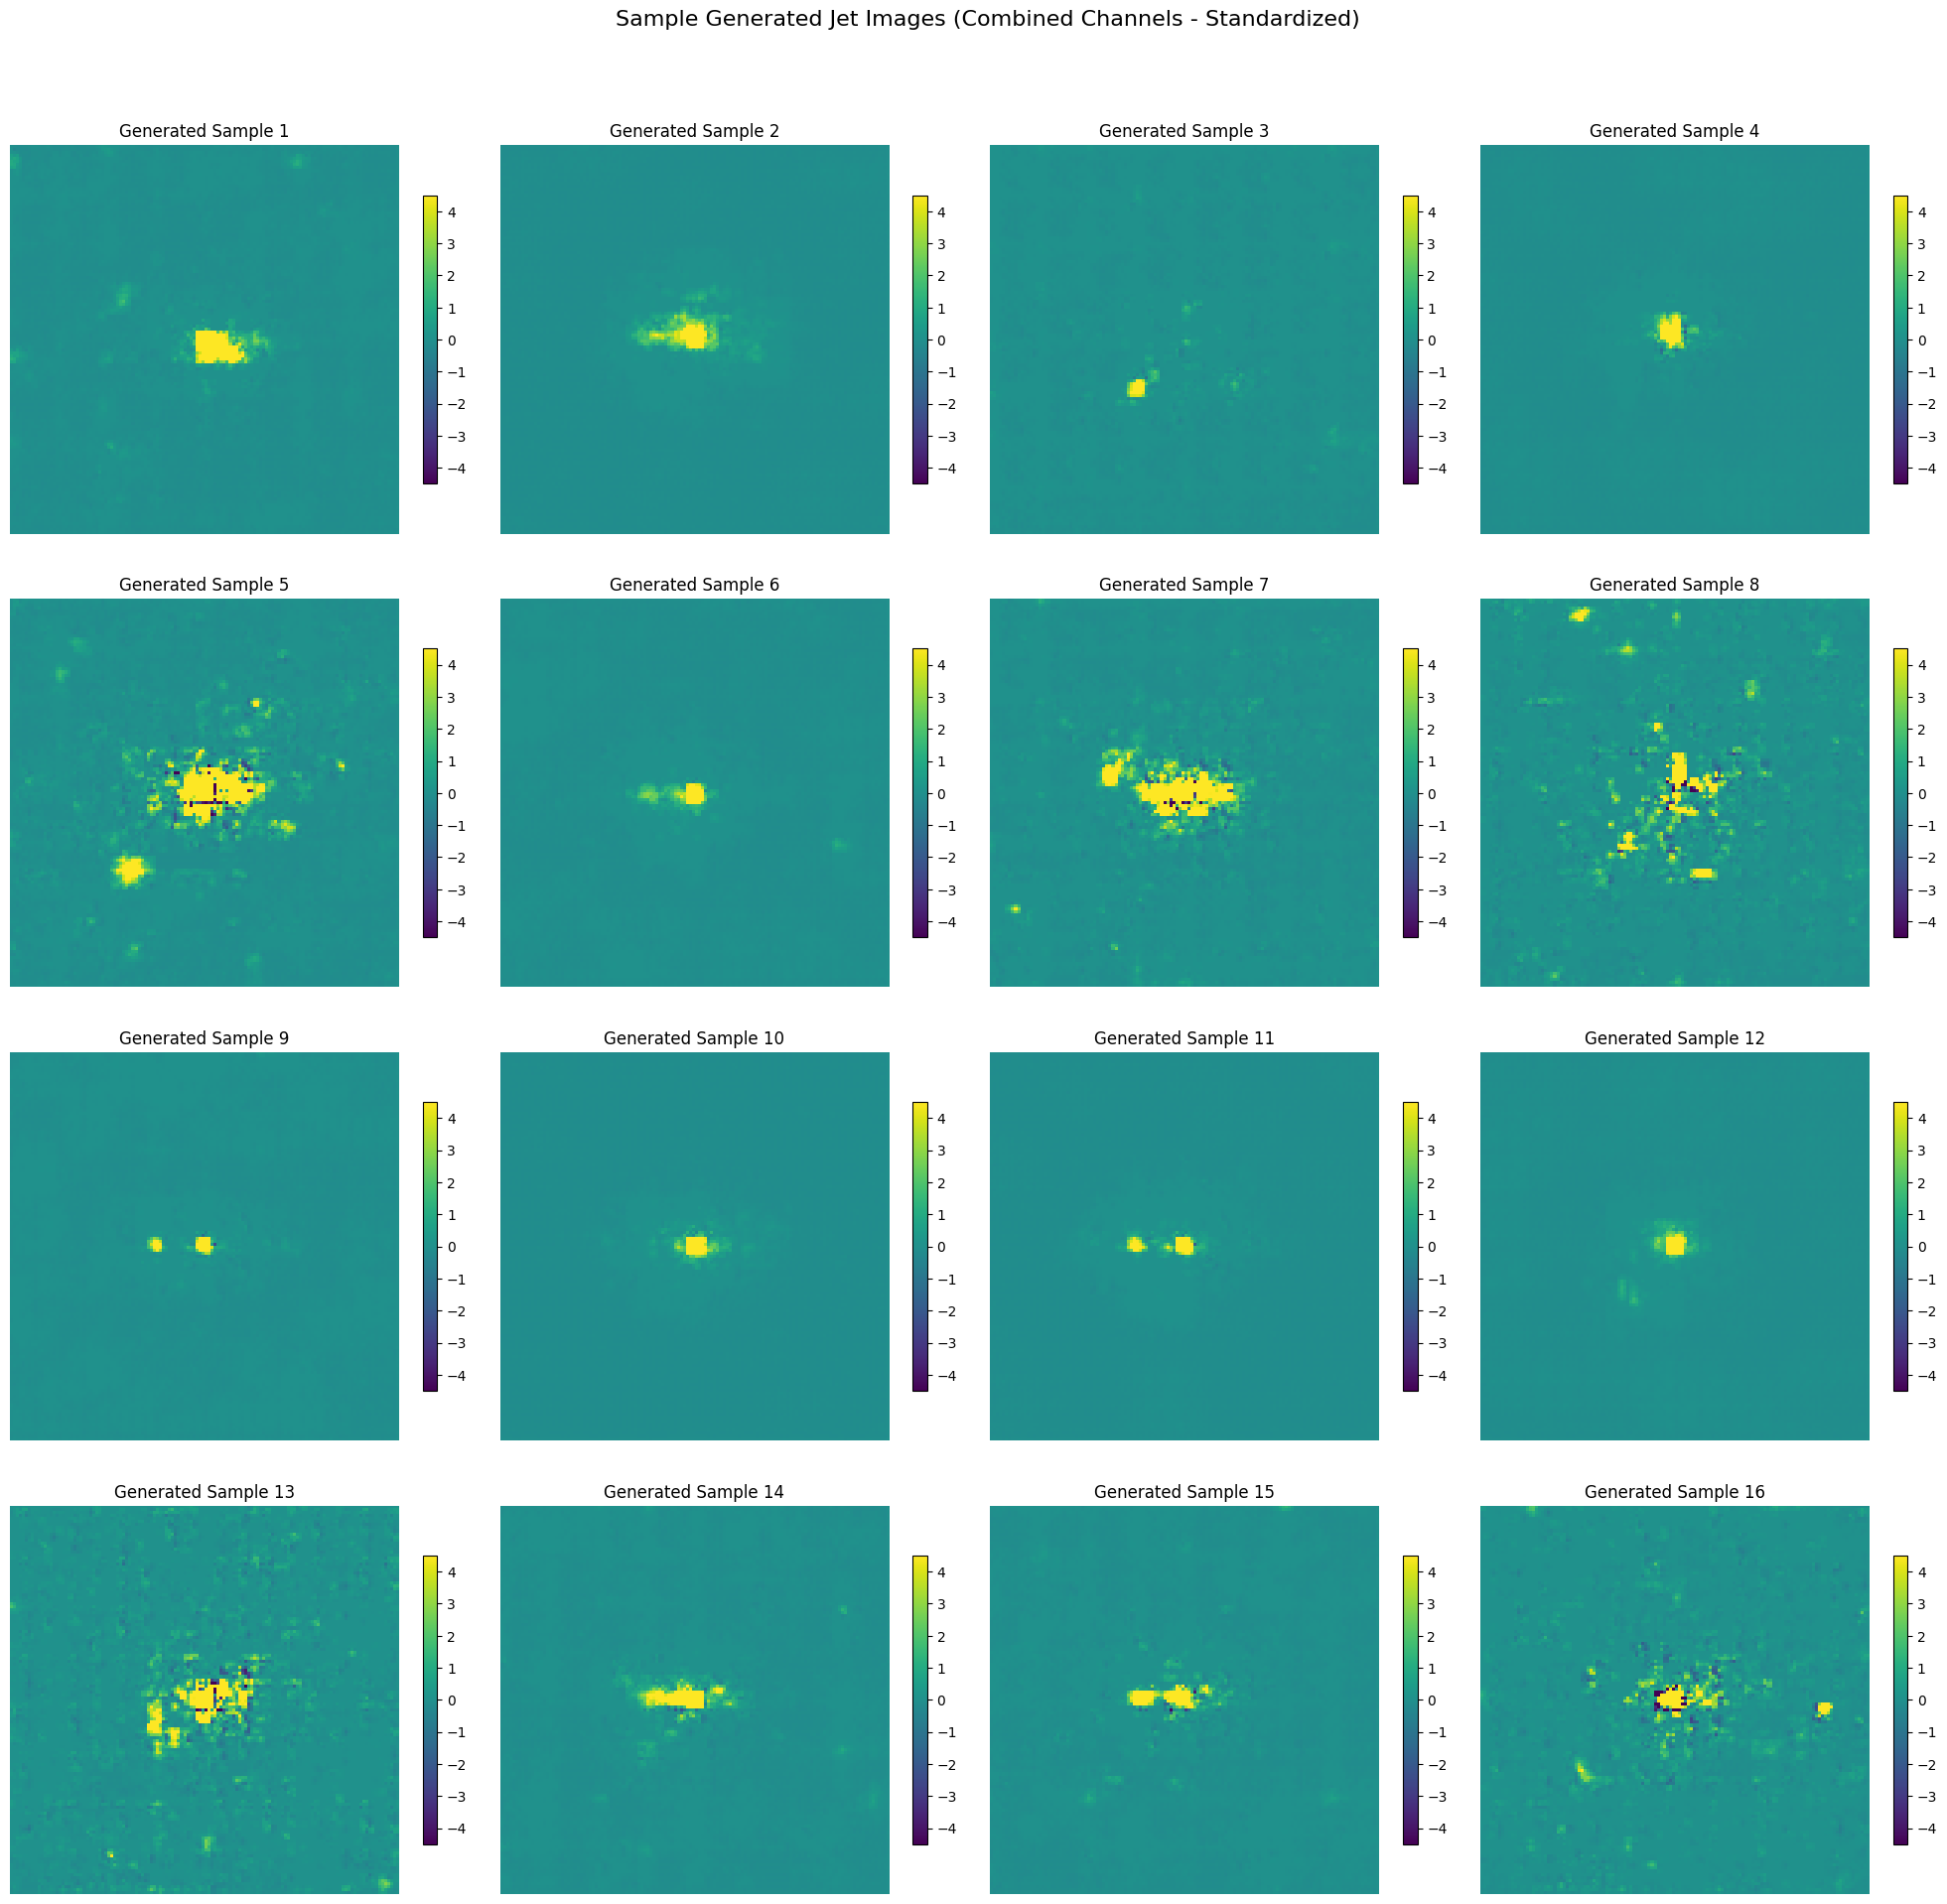


--- Quantitative Evaluation: Comparing Observables (Un-standardized) ---
Un-standardizing images for physical observable comparison...
Calculating observables...
Plotting observable distributions...


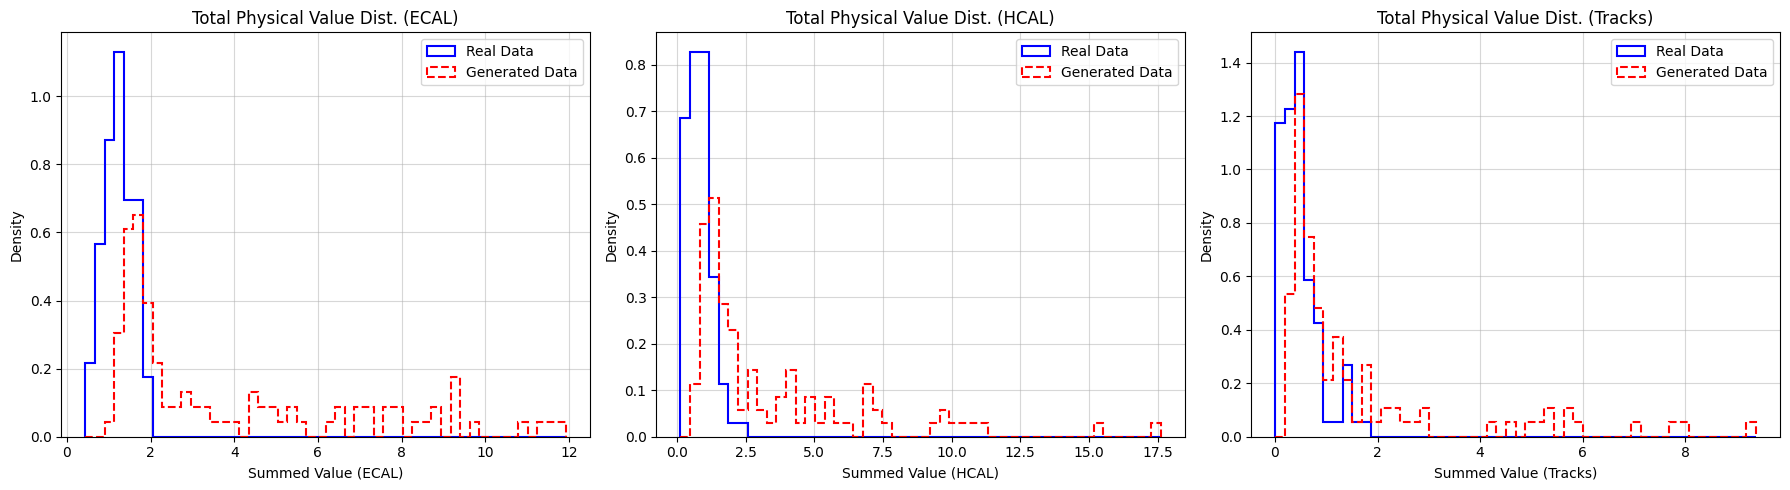

In [ ]:
print("\n--- Qualitative Evaluation: Display Generated Images ---")

num_display = min(NUM_GENERATE, 16)
if generated_images_tensor is None or generated_images_tensor.shape[0] < num_display:
     print("Not enough generated images to display.")
elif num_display > 0:
    display_indices = np.random.choice(generated_images_tensor.shape[0], num_display, replace=False)
    images_to_display = generated_images_tensor[display_indices].numpy()

    if 'vmin_plot' not in locals(): vmin_plot, vmax_plot = -3, 3
    vmin_comb_plot_gen, vmax_comb_plot_gen = vmin_plot * 1.5, vmax_plot * 1.5

    n_rows = math.ceil(num_display / 4)
    fig_gen, axs_gen = plt.subplots(n_rows, 4, figsize=(20, 5 * n_rows))
    axs_gen = np.array(axs_gen).flatten()
    fig_gen.suptitle(f'Sample Generated Jet Images (Combined Channels - Standardized)', fontsize=16)

    for i in range(num_display):
        img_chw = images_to_display[i]
        img_comb = img_chw.sum(axis=0)
        ax = axs_gen[i]
        im = ax.imshow(img_comb, cmap='viridis', vmin=vmin_comb_plot_gen, vmax=vmax_comb_plot_gen)
        ax.set_title(f"Generated Sample {i+1}")
        ax.axis('off')
        if im: fig_gen.colorbar(im, ax=ax, shrink=0.6)

    for j in range(num_display, len(axs_gen)): axs_gen[j].axis('off')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
else:
    print("No generated images to display.")


print("\n--- Quantitative Evaluation: Comparing Observables (Un-standardized) ---")

if ('val_img_dataset' not in locals() or val_img_dataset is None
    or 'generated_images_tensor' not in locals() or generated_images_tensor is None
    or 'channel_means' not in locals() or 'channel_stds' not in locals()):
    print("Required data/variables missing. Skipping quantitative evaluation.")
else:
    num_real_samples = min(len(val_img_dataset), generated_images_tensor.shape[0])
    if num_real_samples == 0:
         print("No validation samples to compare against.")
    else:
        real_indices = np.random.choice(len(val_img_dataset), num_real_samples, replace=False)
        real_images_list = []
        # Handle dataloader yielding list or tensor
        for i in real_indices:
             item = val_img_dataset[i]
             if isinstance(item, (list, tuple)): real_images_list.append(item[0].cpu())
             elif isinstance(item, torch.Tensor): real_images_list.append(item.cpu())

        if not real_images_list:
             print("Could not extract real image tensors. Skipping quantitative comparison.")
        else:
            real_images_tensor = torch.stack(real_images_list)

            print("Un-standardizing images for physical observable comparison...")
            if not isinstance(channel_means, torch.Tensor): channel_means_t = torch.tensor(channel_means, dtype=torch.float32)
            else: channel_means_t = channel_means.cpu().float()
            if not isinstance(channel_stds, torch.Tensor): channel_stds_t = torch.tensor(channel_stds, dtype=torch.float32)
            else: channel_stds_t = channel_stds.cpu().float()
            if channel_means_t.shape != (1,3,1,1): channel_means_t = channel_means_t.reshape(1,3,1,1)
            if channel_stds_t.shape != (1,3,1,1): channel_stds_t = channel_stds_t.reshape(1,3,1,1)

            real_images_unstd = real_images_tensor * channel_stds_t + channel_means_t
            real_images_unstd = torch.relu(real_images_unstd)

            generated_images_comp = generated_images_tensor[:num_real_samples].cpu()
            generated_images_unstd = generated_images_comp * channel_stds_t + channel_means_t
            generated_images_unstd = torch.relu(generated_images_unstd)

            def total_physical_energy(images_tensor_unstd):
                return torch.sum(images_tensor_unstd, dim=(2, 3)).cpu().numpy()

            print("Calculating observables...")
            real_observables = total_physical_energy(real_images_unstd)
            gen_observables = total_physical_energy(generated_images_unstd)

            print("Plotting observable distributions...")
            fig_hist, axs_hist = plt.subplots(1, 3, figsize=(18, 5))
            channel_names = ['ECAL', 'HCAL', 'Tracks']
            bins = 50
            for i in range(3):
                ax = axs_hist[i]; vals_real = real_observables[:, i]; vals_gen = gen_observables[:, i]
                if len(vals_real) == 0 and len(vals_gen) == 0: continue
                min_val = min(vals_real.min() if len(vals_real)>0 else 0, vals_gen.min() if len(vals_gen)>0 else 0)
                max_val = max(vals_real.max() if len(vals_real)>0 else 0, vals_gen.max() if len(vals_gen)>0 else 0)
                max_val = max_val + 0.01 * abs(max_val) if max_val != 0 else 0.1
                bin_edges = np.linspace(min_val, max_val, bins + 1)
                ax.hist(vals_real, bins=bin_edges, histtype='step', density=True, label='Real Data', color='blue', linewidth=1.5)
                ax.hist(vals_gen, bins=bin_edges, histtype='step', density=True, label='Generated Data', color='red', linestyle='--', linewidth=1.5)
                ax.set_title(f'Total Physical Value Dist. ({channel_names[i]})'); ax.set_xlabel(f'Summed Value ({channel_names[i]})'); ax.set_ylabel('Density'); ax.legend(); ax.grid(True, alpha=0.5)
            plt.tight_layout(); plt.show()
